# A blue book for Bulldozers

![ ](bulldozer.jpg " ")

## Overview

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

## Data

For this competition, we are predicting the sale price of bulldozers sold at auctions.

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have. The descriptions all start with "machine configuration" in the data dictionary. Some product types do not have a particular option, so all the records for that option variable will be null for that product type. Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *

In [3]:
DATA_DIR = "data/"
!ls {DATA_DIR}

Machine_Appendix.csv df_merge.frt         dropped_cols.frt
Train.csv            df_merge_2.frt       keep_cols
Valid.csv            df_merge_3.frt       merge_raw.frt
appendix.frt         df_merge_4.frt       train.frt
category_mapper      df_process.frt       train.ftr
df_keep.frt          df_process_2.frt


# Load data

In [5]:
# %time df_train_raw = pd.read_csv(f"{DATA_DIR}Train.csv", low_memory=False, parse_dates=["saledate"])
# %time df_appendix_raw = pd.read_csv(f"{DATA_DIR}Machine_Appendix.csv", low_memory=False)

CPU times: user 1min 32s, sys: 601 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1.04 s, sys: 102 ms, total: 1.14 s
Wall time: 1.15 s


In [7]:
# df_train_raw.to_feather(f"{DATA_DIR}Train.frt")
# df_appendix_raw.to_feather(f"{DATA_DIR}appendix.frt")

In [46]:
%time df_train_raw = pd.read_feather(f"{DATA_DIR}Train.frt")
%time df_appendix_raw = pd.read_feather(f"{DATA_DIR}appendix.frt")

CPU times: user 647 ms, sys: 259 ms, total: 906 ms
Wall time: 905 ms
CPU times: user 280 ms, sys: 89.3 ms, total: 370 ms
Wall time: 368 ms


We merge the two dataframes by the MachineID key

In [ ]:
# df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")
print(df_train_raw.columns)
print(df_appendix_raw.columns)

Merge the two dataframes on the key MachineID, we'll deal later with the duplicate columns fiModelDesc, ...

In [48]:
df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")

In [49]:
df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")

In [5]:
df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")

Save memory by deleting the two originals dataframes

In [ ]:
del df_train_raw
del df_appendix_raw

In [ ]:
df_merge_raw.columns

Now let deal with the duplicate columns.
From the files descriptions we can deduce that the values in the appendix file are more accurate.
But first let have a look at the missing values of each duplicate columns, and verify that we can safely drop columns from the train dataframe

In [6]:
duplicate_columns = ["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries",
                     "fiModelDescriptor", "fiProductClassDesc", "ProductGroup", "ProductGroupDesc", "ModelID"]
temp = {col_name: df_merge_raw[col_name+"_x"].isnull().sum() == df_merge_raw[col_name+"_y"].isnull().sum() for col_name in duplicate_columns}
temp

{'ModelID': True,
 'ProductGroup': True,
 'ProductGroupDesc': True,
 'fiBaseModel': True,
 'fiModelDesc': True,
 'fiModelDescriptor': False,
 'fiModelSeries': False,
 'fiProductClassDesc': True,
 'fiSecondaryDesc': False}

In [7]:
ok_columns = [key for key, val in temp.items() if val == True]
{col_name: [df_merge_raw[col_name+"_x"].isnull().sum(), df_merge_raw[col_name+"_y"].isnull().sum()] for col_name in duplicate_columns}

{'ModelID': [0, 0],
 'ProductGroup': [0, 0],
 'ProductGroupDesc': [0, 0],
 'fiBaseModel': [0, 0],
 'fiModelDesc': [0, 0],
 'fiModelDescriptor': [329206, 326906],
 'fiModelSeries': [344217, 343515],
 'fiProductClassDesc': [0, 0],
 'fiSecondaryDesc': [137191, 135593]}

Some "duplicate columns" does not have the same numbers of missing values, but there are less missing values in columns from the appendix file.
Hence we can drop safely the columns that originate from the train file.

In [8]:
df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)

For convinience we remove the _y of each duplicate columns.

In [9]:
for col_name in duplicate_columns:
    df_merge[col_name] = df_merge[col_name+"_y"]
    df_merge.drop(col_name+"_y", axis=1, inplace=True)

In [61]:
# Let save the dataframe
df_merge.to_feather(f"{DATA_DIR}df_merge.frt")

In [10]:
del df_merge_raw

## Missing values and features engineering

In [98]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")

In [99]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        === Inputs ===
        df: dataframe to analyze
        keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        === Outputs ===
        res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [100]:
missing_values_stats(df_merge)

,Total,Percentage
Pushblock,375906,93.71
Tip_Control,375906,93.71
Engine_Horsepower,375906,93.71
Blade_Extension,375906,93.71
Blade_Width,375906,93.71
Enclosure_Type,375906,93.71
Scarifier,375895,93.71
Hydraulics_Flow,357763,89.19
Grouser_Tracks,357763,89.19
Coupler_System,357667,89.17


### Years
From description MfgYear should be the correct version of YearMade. Let compare them to check if we can drop YearMade safely.

In [101]:
(df_merge["YearMade"] != df_merge["MfgYear"]).sum()

33864

The two columns have 33864 different entries.
Before dropping YearMade, let see if some weird values from MfgYear can be correct using YearMade.

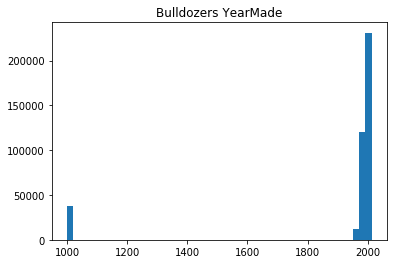

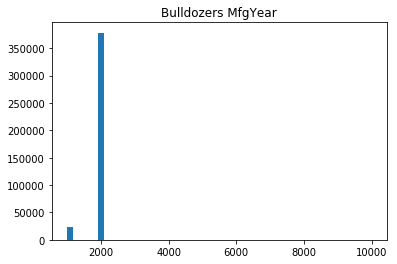

In [102]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

Clearly their are some weird values: 
 - In MfgYear there are some values in the 10000's, we should replace them with the values in YearMade
 - In both features there are some bulldozers build in the 1000's which is obviously wrong, let see if there are the same in each columns

In [103]:
df_merge[df_merge.MfgYear > 2012]

,SalesID,SalePrice,MachineID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,ProductSize,...,PrimaryUpper,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,ModelID
168998,1579170,20500,884218,132,22.0,1996,NaN,None,2009-11-21,Compact,...,1000000.0,848G,848,G,None,None,"Skidder, Wheel - 161.0 + Horsepower",SKID,Skidders,4839


In [104]:
df_merge.loc[df_merge.MfgYear > 2012, "MfgYear"] = 1996

Only one incorrect value in MfgYear greater than 2012, we replaced it by the YearMade value.

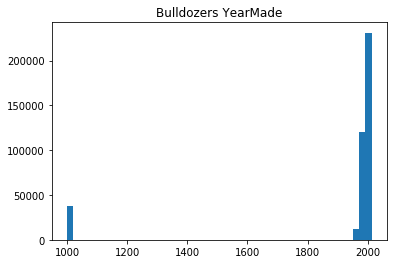

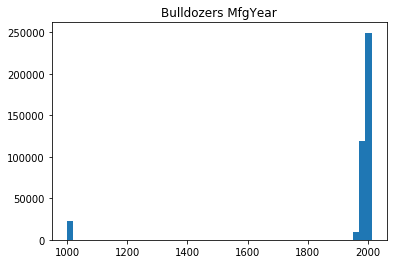

In [105]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

In [106]:
print("YearMade < 1900: ", len(df_merge[df_merge.YearMade < 1900]))
print("MfgYear < 1900: ", len(df_merge[df_merge.MfgYear < 1900]))

YearMade < 1900:  38185
MfgYear < 1900:  22554


We learn from the above graphs that there are more values lesser than 1900 in YearMade than MfgYear.
We need to check if the the values in MfgYear are contains in YearMade.

In [107]:
MfgYear_idx = df_merge[df_merge.MfgYear < 1900].index
YearMade_idx = df_merge[df_merge.YearMade < 1900].index
[e for e in MfgYear_idx if e not in YearMade_idx]

[]

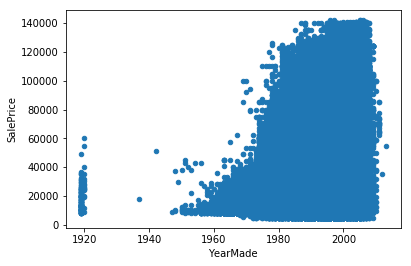

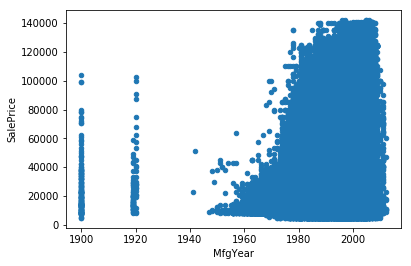

In [108]:
df_merge[df_merge.YearMade >= 1900].plot("YearMade", "SalePrice", "scatter")
plt.show()
df_merge[df_merge.MfgYear >= 1900].plot("MfgYear", "SalePrice", "scatter")

From the above graphs we can see that there others irregularities in the values of YearMade and MfgYear.
Futhermore, there is a line of values dated at 1900 in MfgYear that not appers in YearMade.
We'll replace the values of the 1900 line in MfgYear by the values in YearMade.

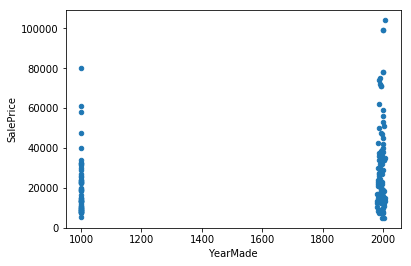

In [109]:
df_merge.iloc[df_merge[df_merge.MfgYear == 1900].index].plot("YearMade", "SalePrice", "scatter")

In [110]:
df_merge["MfgYear_correct"] = df_merge["MfgYear"]

In [111]:
df_merge.loc[df_merge.MfgYear == 1900, "MfgYear_correct"] = df_merge[df_merge.MfgYear == 1900]["YearMade"]

In [112]:
print("values <= 1920:", len(df_merge[df_merge.MfgYear_correct <=1920]), "  ", np.round(len(df_merge[df_merge.MfgYear_correct <=1920])/len(df_merge), 3), "%")

values <= 1920: 22695    0.057 %


Now to deal with the 1920's line, there is to much incorrect values to manually correct them. They represents less than 0.06% of the dataset, we can drop them without risk.

In [113]:
dropped_columns = pd.DataFrame()
dropped_columns["YearMade"] = df_merge["YearMade"]
dropped_columns["MfgYear"] = df_merge["MfgYear"]

In [114]:
df_merge.drop(["YearMade", "MfgYear"], axis=1, inplace=True)

In [115]:
df_merge.drop(df_merge[df_merge.MfgYear_correct <= 1920].index, axis=0, inplace=True)

In [116]:
df_merge["MfgYear_correct"] = df_merge["MfgYear_correct"].dropna()

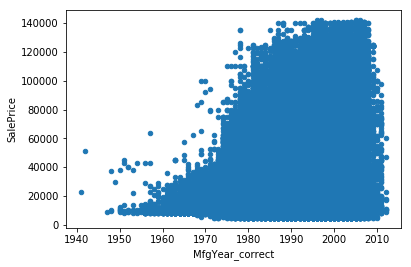

In [117]:
df_merge.plot("MfgYear_correct", "SalePrice", "scatter")

Finally we have a correct range of values for the manufacturing date. 

In [118]:
# reset index
df_merge = df_merge.reset_index(drop=True)

In [119]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")
dropped_columns.to_feather(f"{DATA_DIR}dropped_cols.frt")

In [120]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with dates

In [121]:
def date_infos(df_in, col_name, drop=True, inplace=False):
    """
    Extract infos (Year, Month, Day, Dayofweek,...) from a column containning dates. 
    
    === Inputs ===
    df_in: input dataframe.
    col_name: name of the column containning dates.
    drop: boolean that indicate if the column col_name has to be dropped.
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    A data frame.
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    # Convert the date column to right dtype if needed
    if not np.issubdtype(df[col_name].dtype, np.datetime64):
        df[col_name] = pd.to_datetime(df[col_name], infer_datetime_format=True)
    new_idx_prefix = re.sub('[Dd]ate$', '', col_name)
    for c in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
              'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[new_idx_prefix+"_"+c] = getattr(df[col_name].dt, c.lower())
    df[new_idx_prefix+'_Elapsed'] = df[col_name].astype(np.int64) // 10**9
    if drop:
        df.drop(col_name, axis=1, inplace=True)
    return df

In [122]:
# Extract all infos from the columns date
df_merge = date_infos(df_merge, "saledate")

In [123]:
df_merge.head()

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Day,sale_Dayofweek,sale_Dayofyear,sale_Is_month_end,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed
0,1139246,66000,999089,121,3.0,68.0,Low,None,Alabama,None,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,57000,117657,121,3.0,4640.0,Low,Medium,North Carolina,None,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,10000,434808,121,3.0,2838.0,High,None,New York,None,...,26,3,57,False,False,False,False,False,False,1077753600
3,1398858,12000,434808,132,2.0,NaN,None,None,Kentucky,None,...,23,4,114,False,False,False,False,False,False,1082678400
4,1398859,12500,434808,132,2.0,NaN,None,None,Texas,None,...,17,2,77,False,False,False,False,False,False,1079481600


In [124]:
df_merge["age"] = df_merge["sale_Year"] - df_merge["MfgYear_correct"]

In [126]:
len(df_merge[df_merge.age < 0]), len(df_merge[df_merge.age < 0])/len(df_merge)

(2283, 0.0060328198081547445)

In [127]:
df_merge.drop(df_merge[df_merge.age < 0].index, axis=0, inplace=True)

In [128]:
df_merge = df_merge.reset_index(drop=True)

In [129]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")

### Dealing with categorical features
We start by seperate into two groups the features: categorical and numerical.
Then we study briefly the categorical features, we remark that some features have a "None or Unspecified" category. So when possible we replace missing categories by it.

In [130]:
numerical_features = [col_name for col_name in df_merge.columns if not (pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype))]
categorical_features = [col_name for col_name in df_merge.columns if pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype)]

In [131]:
numerical_features

['SalesID',
 'SalePrice',
 'MachineID',
 'datasource',
 'auctioneerID',
 'MachineHoursCurrentMeter',
 'fiManufacturerID',
 'PrimaryLower',
 'PrimaryUpper',
 'ModelID',
 'MfgYear_correct',
 'sale_Year',
 'sale_Month',
 'sale_Week',
 'sale_Day',
 'sale_Dayofweek',
 'sale_Dayofyear',
 'sale_Is_month_end',
 'sale_Is_month_start',
 'sale_Is_quarter_end',
 'sale_Is_quarter_start',
 'sale_Is_year_end',
 'sale_Is_year_start',
 'sale_Elapsed',
 'age']

We see above that some numerical features missclassified and should be categorical.

In [132]:
sorted({feat: len(df_merge[feat].unique()) for feat in numerical_features}.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('MachineHoursCurrentMeter', 14933),
 ('ModelID', 5300),
 ('sale_Elapsed', 3894),
 ('SalePrice', 881),
 ('sale_Dayofyear', 360),
 ('fiManufacturerID', 101),
 ('PrimaryLower', 74),
 ('PrimaryUpper', 71),
 ('MfgYear_correct', 68),
 ('age', 63),
 ('sale_Week', 53),
 ('auctioneerID', 31),
 ('sale_Day', 31),
 ('sale_Year', 23),
 ('sale_Month', 12),
 ('sale_Dayofweek', 7),
 ('datasource', 5),
 ('sale_Is_month_end', 2),
 ('sale_Is_month_start', 2),
 ('sale_Is_quarter_end', 2),
 ('sale_Is_quarter_start', 2),
 ('sale_Is_year_end', 2),
 ('sale_Is_year_start', 1)]

In [133]:
# Features with ID should be categorical
categorical_features.extend(["MachineID", "ModelID", "SalesID", "auctioneerID", "datasource", "fiManufacturerID"])

In [134]:
# Convert the supposed categorical features into categeory in the dataframe
for feat in categorical_features:
    df_merge[feat] = df_merge[feat].astype("category")

In [135]:
temp = {feat: len(df_merge[feat].unique()) for feat in df_merge.columns if pd.api.types.is_categorical(df_merge[feat])}
sorted(temp.items(), key=operator.itemgetter(1), reverse=True)

[('SalesID', 376147),
 ('MachineID', 318810),
 ('ModelID', 5300),
 ('fiModelDesc', 5069),
 ('fiBaseModel', 1971),
 ('fiSecondaryDesc', 183),
 ('fiProductClassDesc', 153),
 ('fiModelDescriptor', 152),
 ('fiModelSeries', 142),
 ('fiManufacturerID', 101),
 ('fiManufacturerDesc', 101),
 ('state', 53),
 ('ProductGroup', 37),
 ('ProductGroupDesc', 37),
 ('auctioneerID', 31),
 ('Stick_Length', 29),
 ('Undercarriage_Pad_Width', 20),
 ('Tire_Size', 18),
 ('Hydraulics', 13),
 ('Blade_Type', 11),
 ('Transmission', 9),
 ('Travel_Controls', 8),
 ('PrimarySizeBasis', 8),
 ('ProductSize', 7),
 ('Enclosure', 7),
 ('Blade_Width', 7),
 ('Steering_Controls', 6),
 ('datasource', 5),
 ('Drive_System', 5),
 ('Pad_Type', 5),
 ('Ripper', 5),
 ('Differential_Type', 5),
 ('UsageBand', 4),
 ('Ride_Control', 4),
 ('Enclosure_Type', 4),
 ('Tip_Control', 4),
 ('Coupler', 4),
 ('Hydraulics_Flow', 4),
 ('Thumb', 4),
 ('Pattern_Changer', 4),
 ('Grouser_Type', 4),
 ('Forks', 3),
 ('Stick', 3),
 ('Turbocharged', 3),
 ('

In [136]:
df_merge["Backhoe_Mounting"].unique()

[NaN, None or Unspecified, Yes]
Categories (2, object): [None or Unspecified, Yes]

In [137]:
# For each categorical features, if a "None or Unspecified" category exist we replace evry missing values by it
for col_name in df_merge.columns:
    if pd.api.types.is_categorical_dtype(df_merge[col_name]):
        if df_merge[col_name].isnull().sum() > 0 and "None or Unspecified" in df_merge[col_name].unique():
            df_merge[col_name] = df_merge[col_name].fillna("None or Unspecified")

In [138]:
# Save mapper from code to category and vice-versa for each categorical features
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}
category_inv_mapper = {col_name: {idx: code for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}

In [139]:
def numericalize(df_in, inplace=False):
    """
    Convert the categorical features of the dataframe into numerical values.
    
    === Inputs ===
    df_in: dataframe to numericalize
    inplace: boolean that indicate if the transformation is done inplace
    
    === Output ===
    a dataframe with categorical features convert into numerical features
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[col_name] = col.cat.codes + 1 # +1 because Nan have -1 code
    return df

In [140]:
numericalize(df_merge, inplace=True)

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Dayofweek,sale_Dayofyear,sale_Is_month_end,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed,age
0,1,66000,60492,1,4,68.0,2,0,1,0,...,3,320,False,False,False,False,False,False,1163635200,2.0
1,2,57000,9294,1,4,4640.0,2,4,33,0,...,4,86,False,False,False,False,False,False,1080259200,8.0
2,3,10000,27886,1,4,2838.0,1,0,32,0,...,3,57,False,False,False,False,False,False,1077753600,3.0
3,87574,12000,27886,2,3,NaN,0,0,17,0,...,4,114,False,False,False,False,False,False,1082678400,3.0
4,87575,12500,27886,2,3,NaN,0,0,44,0,...,2,77,False,False,False,False,False,False,1079481600,3.0
5,4,38500,66511,1,4,3486.0,1,6,44,0,...,3,139,False,False,False,False,False,False,1305763200,1.0
6,5,11000,73210,1,4,722.0,3,0,32,0,...,3,204,False,False,False,False,False,False,1248307200,2.0
7,6,26500,60975,1,4,508.0,2,0,3,2,...,3,353,False,False,False,False,False,False,1229558400,4.0
8,7,21000,47241,1,4,11540.0,1,3,9,0,...,3,239,False,False,False,False,False,False,1093478400,5.0
9,10719,29500,47241,1,4,1080.0,2,5,44,0,...,3,236,False,False,False,False,False,False,1156377600,7.0


Now every categorical features have been dealt with, ie, missing values replaced and category converted in numbers.
### Dealing we numerical features

In [141]:
def fix_numerical_missing_values(df_in, inplace=False):
    """
    Replace missing values of a numerical feature by the median of the column.
    Plus, add boolean column that indicate if the value was missing.
    
    === Inputs ===
    df_in: dataframe to fix
    inplace: boolean that indicate if the transformation is done inplace.
    
    === Outputs ===
    a dataframe without missing values in the numerical features. 
    """
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_numeric_dtype(col):
            if col.isnull().sum():
                df[col_name+"_na"] = col.isnull()
                df[col_name] = col.fillna(col.dropna().median())
    return df

In [142]:
df_merge = fix_numerical_missing_values(df_merge)

In [143]:
missing_values_stats(df_merge)

,Total,Percentage


Finally no more missing values in the data frame.
Before building a model, let draw a pairplot of the dataframe.

In [144]:
df_merge.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'datasource', 'auctioneerID',
       'MachineHoursCurrentMeter', 'UsageBand', 'ProductSize', 'state',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'fiManufacturerID', 'fiManufacturerDesc', 'PrimarySizeBasis',
       'PrimaryLower', 'PrimaryUpper', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'ModelID',


In [145]:
df_merge.to_feather(f"{DATA_DIR}df_merge_3.frt")

## Model baseline random forest

In [146]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_3.frt")

In [147]:
# We sort the dateframe by saleElapse because sale are time dependant and validation set is the last 2 monts sales
# df_merge = df_merge.sort_values("sale_Elapsed", ascending=False)

In [148]:
sale_price = np.log(df_merge["SalePrice"])

In [149]:
dropped_cols = pd.DataFrame()
dropped_cols["SalePrice"] = df_merge["SalePrice"]

In [150]:
df_merge.drop("SalePrice", axis=1, inplace=True)

In [152]:
def split_vals(a, n):
    """
    Split the frame into two frames of size len(a)-n et n
    """
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_merge)-n_valid
x_train, x_valid = split_vals(df_merge, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((364147, 75), (364147,), (12000, 75), (12000,))

In [153]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)

%time random_forest.fit(x_train, y_train)

CPU times: user 8min 5s, sys: 2.85 s, total: 8min 8s
Wall time: 1min 12s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [154]:
def rmse(x, y):
    """
    Cost function for the evaluation
    """
    return math.sqrt(((x-y)**2).mean())

def get_scores(rf, x_train, y_train, x_valid, y_valid):
    """
    compute the RMSE and accuracy for the train et validation set. If the oob_score is avalaible, it's added to the frame.
    """
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "RF score train": rf.score(x_train, y_train), "RF score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"RF oob": rf.oob_score_})
    return score

In [155]:
scores = pd.DataFrame({"baseline": get_scores(random_forest, x_train, y_train, x_valid, y_valid)})

In [156]:
scores

,baseline
RF oob,0.908443
RF score train,0.987253
RF score valid,0.897001
RMSE train,0.077716
RMSE valid,0.240695


This simple model will served as baseline. The RMSE for the validation is ~0.239, which place us in the 45th position out of 470 of the kaggle public leaderbord. 
Still, the model clearly overfit as the score on the training set is much better than the validation set.
Hence, we'll look at the features importances to reduce the overfit et improve the model.

## First Partial dependance analysis

In [157]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [158]:
df_aux = df_merge.copy()
df_aux["SalePrice"] = sale_price
df_sample = get_sample(df_aux, 1000)

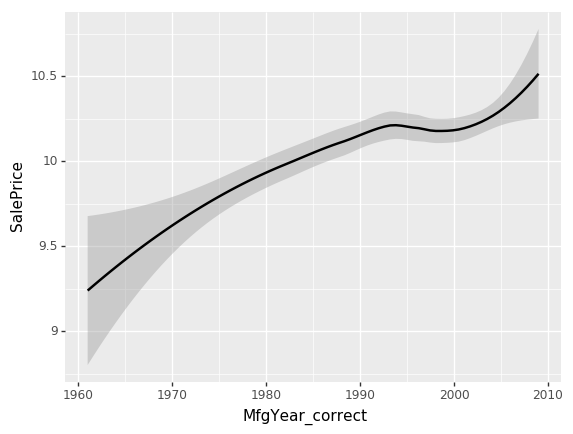

<ggplot: (8053208759)>

In [159]:
ggplot(df_sample, aes('MfgYear_correct', 'SalePrice'))+stat_smooth(se=True, method='loess')

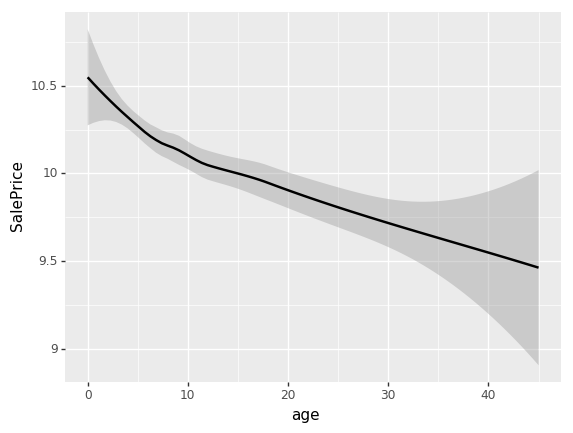

<ggplot: (-9223372029237444180)>

In [160]:
ggplot(df_sample, aes('age', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [161]:
x_train_aux = get_sample(x_train, 1000)

In [162]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(random_forest, x_train_aux, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

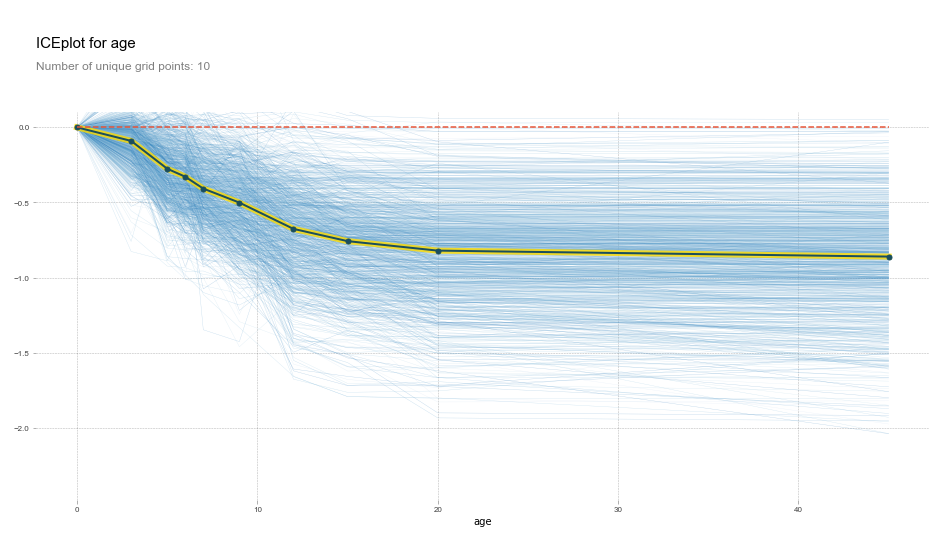

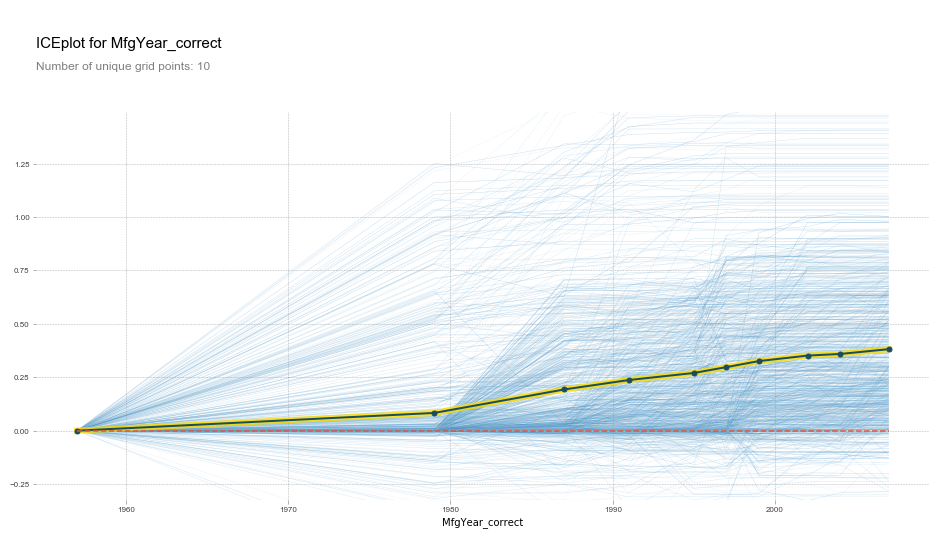

In [163]:
plot_pdp("age")
plot_pdp("MfgYear_correct")

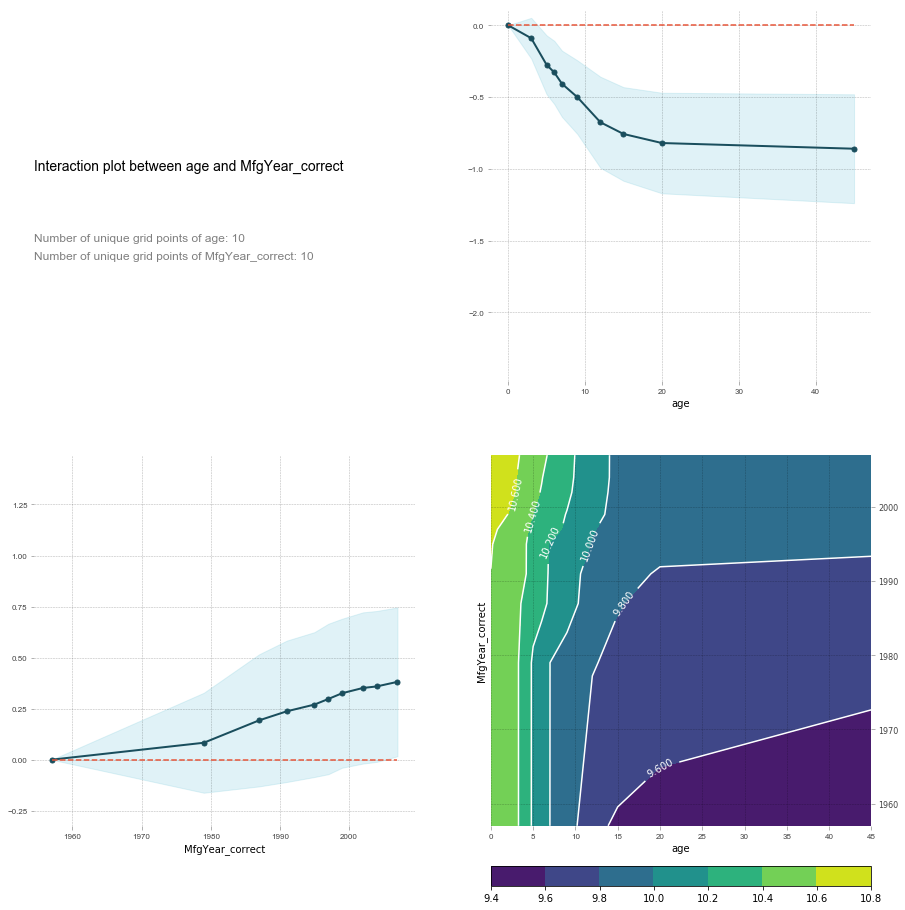

In [164]:
feats = ['age', 'MfgYear_correct']
p = pdp.pdp_interact(random_forest, x_train_aux, feats)
pdp.pdp_interact_plot(p, feats)

## Features importances

In [165]:
def get_features_importance(model, df):
    return pd.DataFrame({"cols": df.columns, "imp": model.feature_importances_}).sort_values("imp", ascending=False)

In [166]:
feat_importance = get_features_importance(random_forest, df_merge)

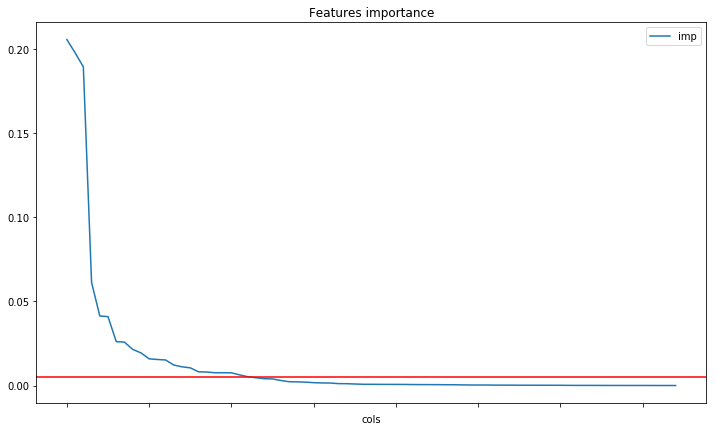

In [167]:
feat_importance.plot("cols", "imp", title="Features importance", figsize=(12,7))
plt.axhline(y=0.005, color="r")

In [168]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

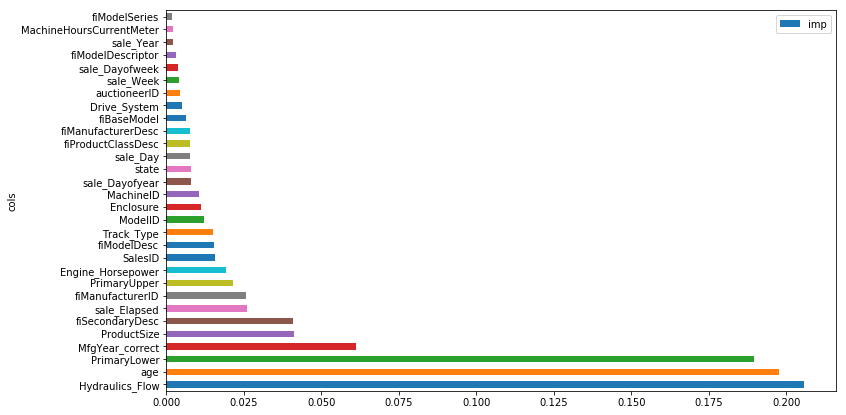

In [169]:
plot_feat_importance(feat_importance[:30])

In [170]:
feat_importance = feat_importance[feat_importance.imp > .005]
len(feat_importance)

23

In [171]:
with open(f"{DATA_DIR}keep_cols", "wb") as handle:
    pickle.dump(feat_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [172]:
df_keep = df_merge[feat_importance.cols]
df_keep.head()

,Hydraulics_Flow,age,PrimaryLower,MfgYear_correct,ProductSize,fiSecondaryDesc,sale_Elapsed,fiManufacturerID,PrimaryUpper,Engine_Horsepower,...,ModelID,Enclosure,MachineID,sale_Dayofyear,state,sale_Day,fiProductClassDesc,fiManufacturerDesc,fiBaseModel,Drive_System
0,2,2.0,110.0,2004.0,0,44,1163635200,8,120.0,0,...,652,3,60492,320,1,16,137,15,315,0
1,2,8.0,150.0,1996.0,4,61,1080259200,9,175.0,0,...,11,3,9294,86,33,26,140,16,568,0
2,3,3.0,1351.0,2001.0,0,0,1077753600,9,1601.0,0,...,1582,6,27886,57,32,26,105,16,118,0
3,3,3.0,1351.0,2001.0,0,0,1082678400,9,1601.0,0,...,1582,6,27886,114,17,23,105,16,118,0
4,3,3.0,1351.0,2001.0,0,0,1079481600,9,1601.0,0,...,1582,6,27886,77,44,17,105,16,118,0


In [173]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 23), (364147,), (12000, 23))

In [174]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 40s, sys: 1.98 s, total: 4min 42s
Wall time: 42.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [176]:
#scores.drop("feat_importance", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"feat_importance": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [177]:
scores

,baseline,feat_importance
RF oob,0.908443,0.906236
RF score train,0.987253,0.986913
RF score valid,0.897001,0.899099
RMSE train,0.077716,0.078745
RMSE valid,0.240695,0.238231


### Redundant features

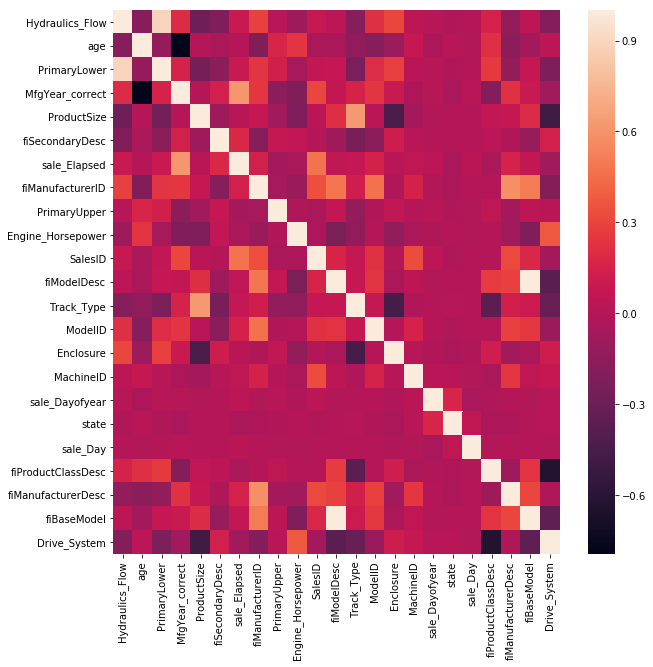

In [178]:
corr=df_keep.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

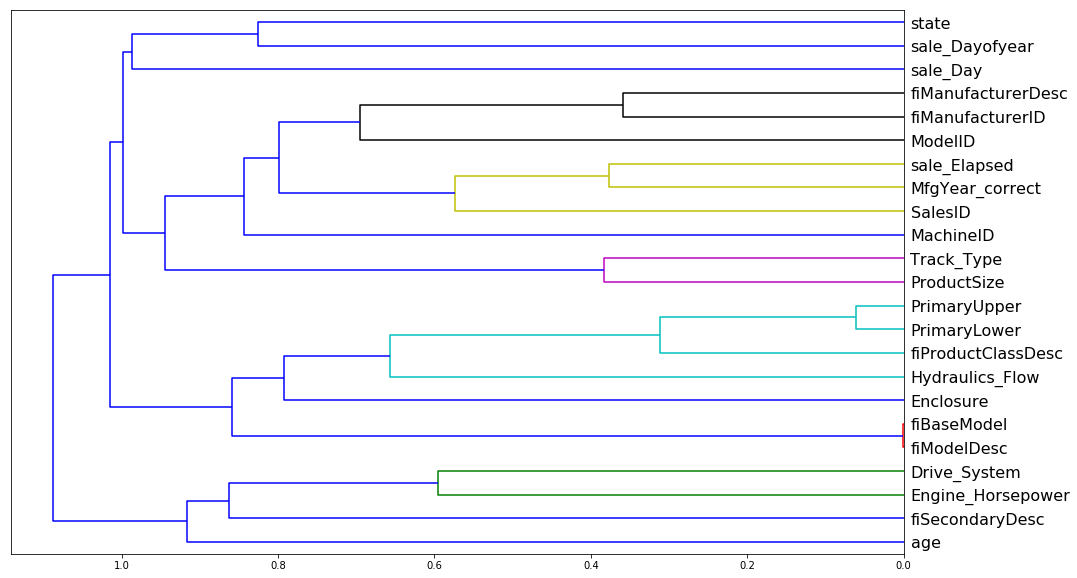

In [179]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [180]:
def get_oob(df, y_train, n_trn):
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    rf.fit(x, y_train)
    return rf.oob_score_

In [181]:
get_oob(df_keep, y_train, n_trn)

0.90600544151183848

In [182]:
for col_name in ["fiBaseModel", "fiModelDesc"]:
    print(col_name+": ", get_oob(df_keep.drop(col_name, axis=1), y_train, n_trn))

fiBaseModel:  0.906023481285
fiModelDesc:  0.90575595725


In [183]:
df_keep.drop("fiBaseModel", axis=1, inplace=True)

In [184]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((364147, 22), (364147,), (12000, 22))

In [185]:
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 27s, sys: 1.96 s, total: 4min 29s
Wall time: 39.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [186]:
scores = scores.join(pd.DataFrame({"correlation": get_scores(random_forest, x_train, y_train, x_valid, y_valid)}))

In [187]:
scores

,baseline,feat_importance,correlation
RF oob,0.908443,0.906236,0.906254
RF score train,0.987253,0.986913,0.986910
RF score valid,0.897001,0.899099,0.898384
RMSE train,0.077716,0.078745,0.078754
RMSE valid,0.240695,0.238231,0.239074


In [188]:
df_keep.to_feather(f"{DATA_DIR}df_keep.frt")

### Partial dependance

In [109]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [116]:
df_aux = df_keep.copy()
df_aux["SalePrice"] = sale_price
df_sample = get_sample(df_aux, 5000)

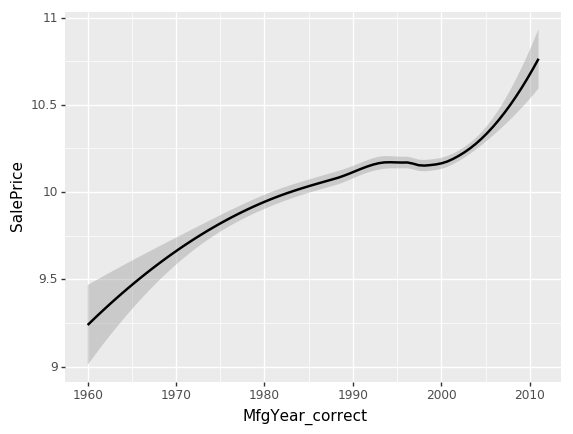

<ggplot: (-9223372029272260692)>

In [117]:
ggplot(df_sample, aes('MfgYear_correct', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [126]:
x_train_aux = get_sample(x_train, 1000)

In [127]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(random_forest, x_train_aux, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

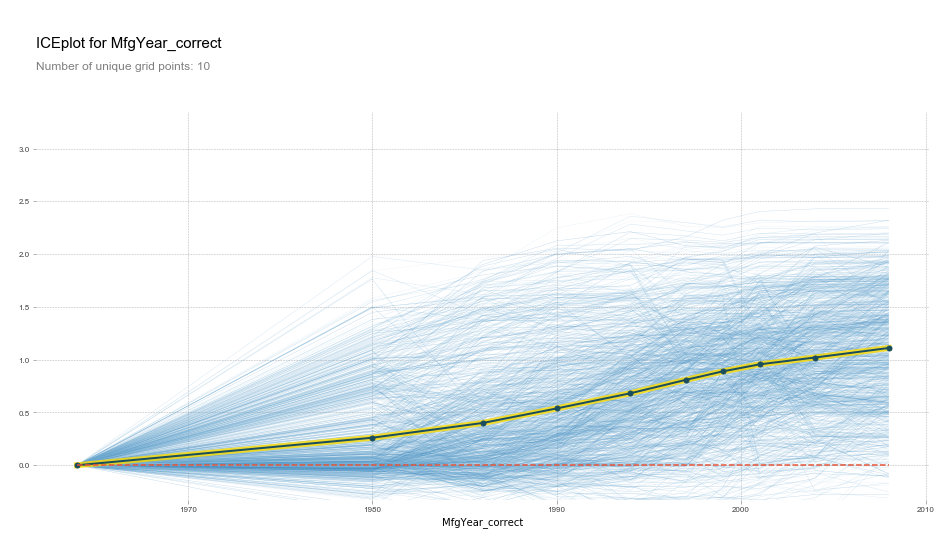

In [128]:
plot_pdp('MfgYear_correct')

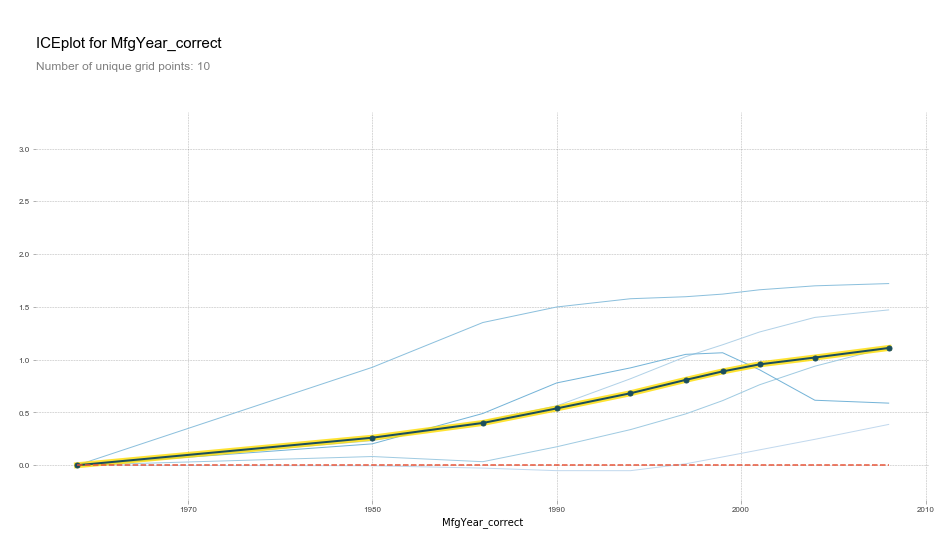

In [129]:
plot_pdp('MfgYear_correct', clusters=5)

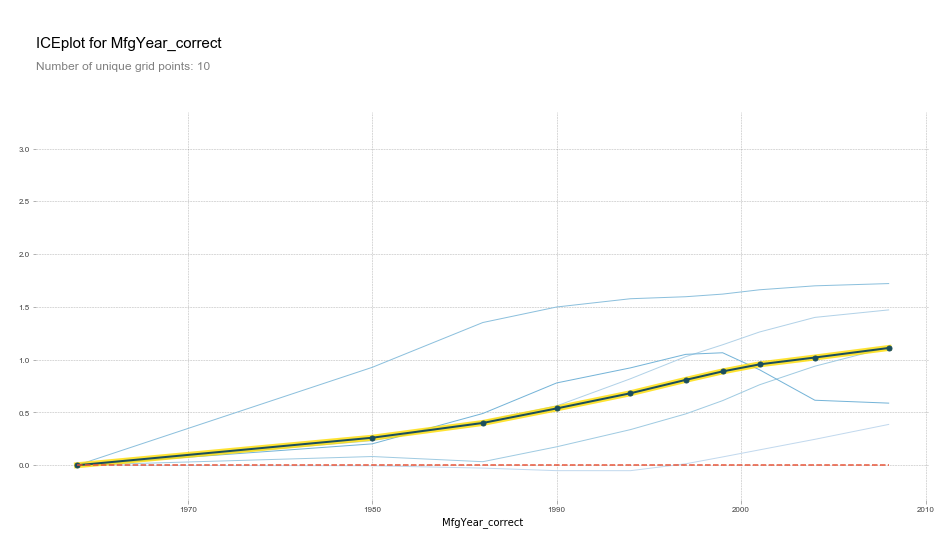

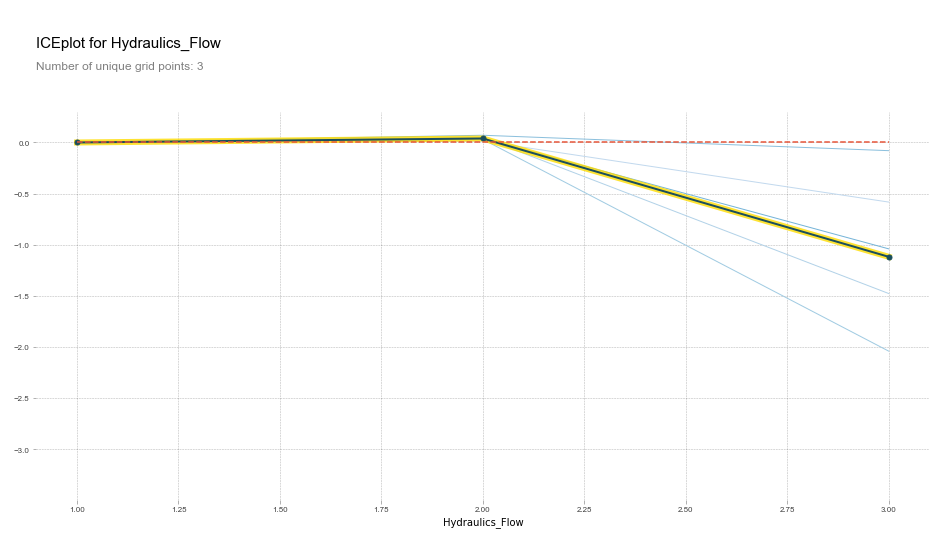

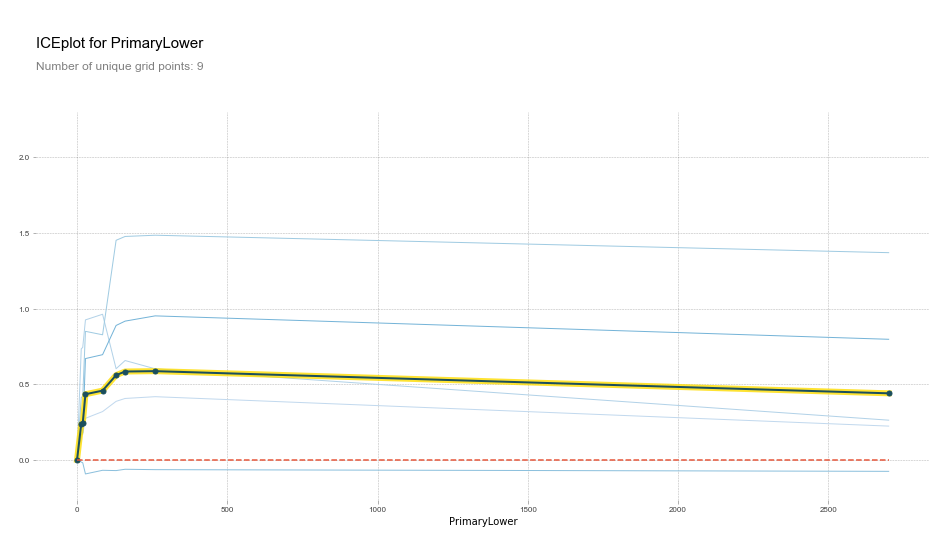

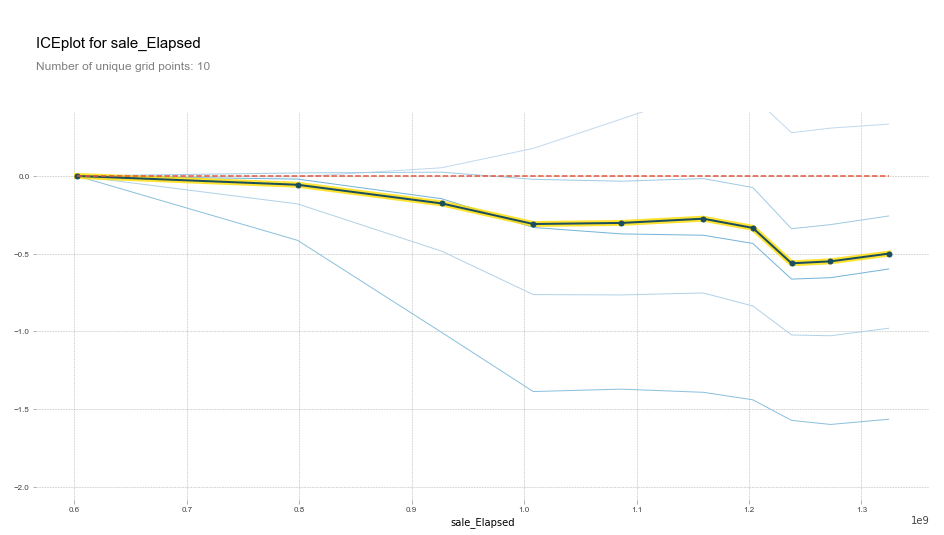

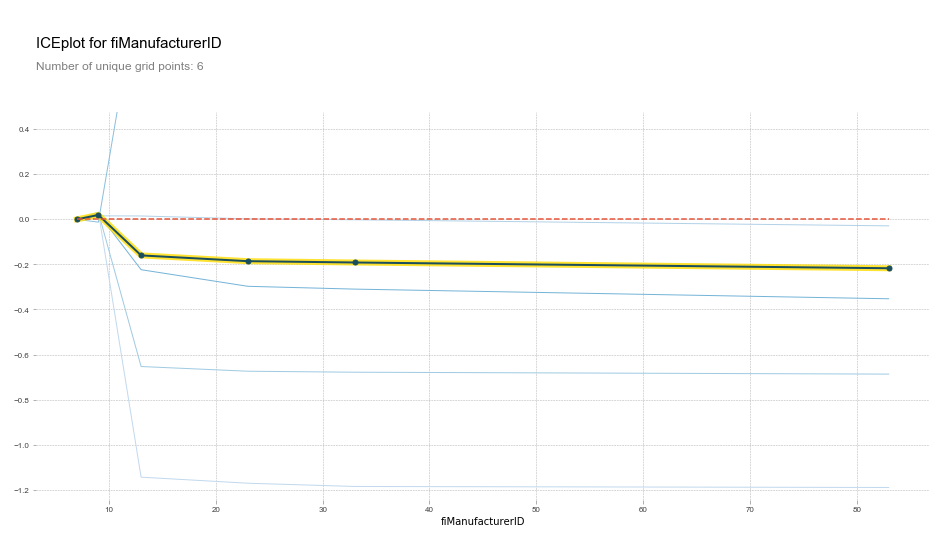

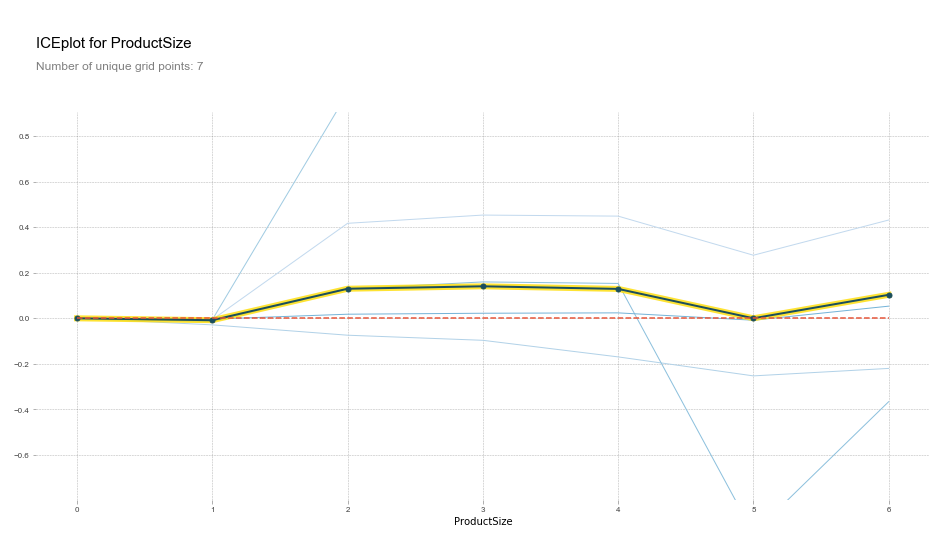

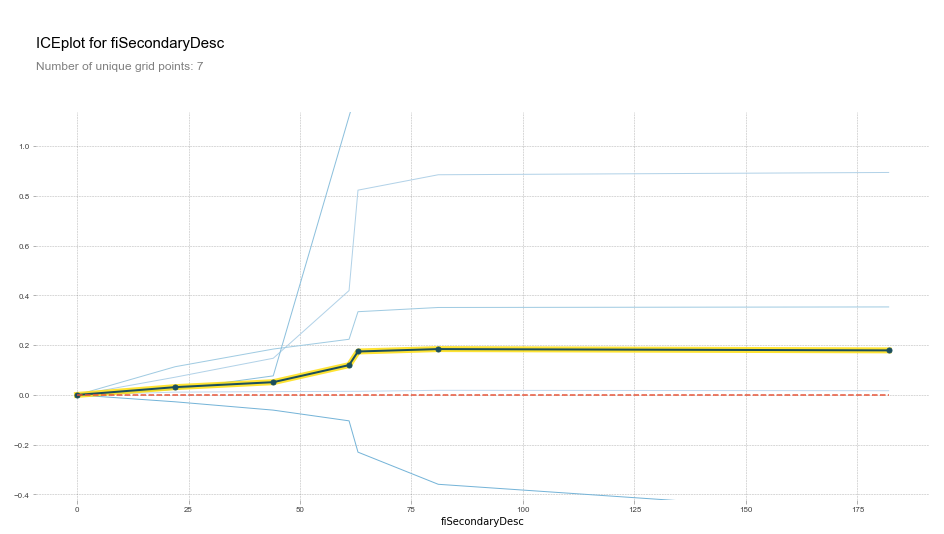

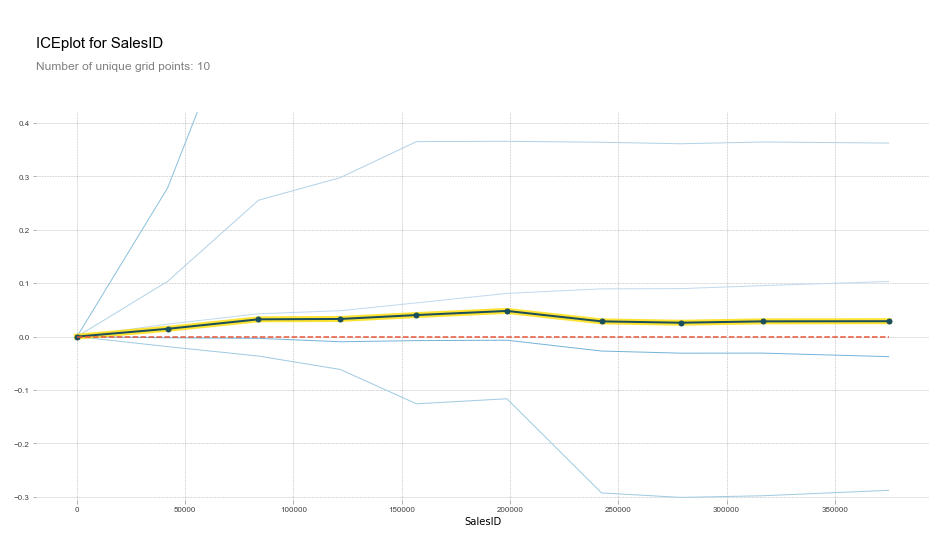

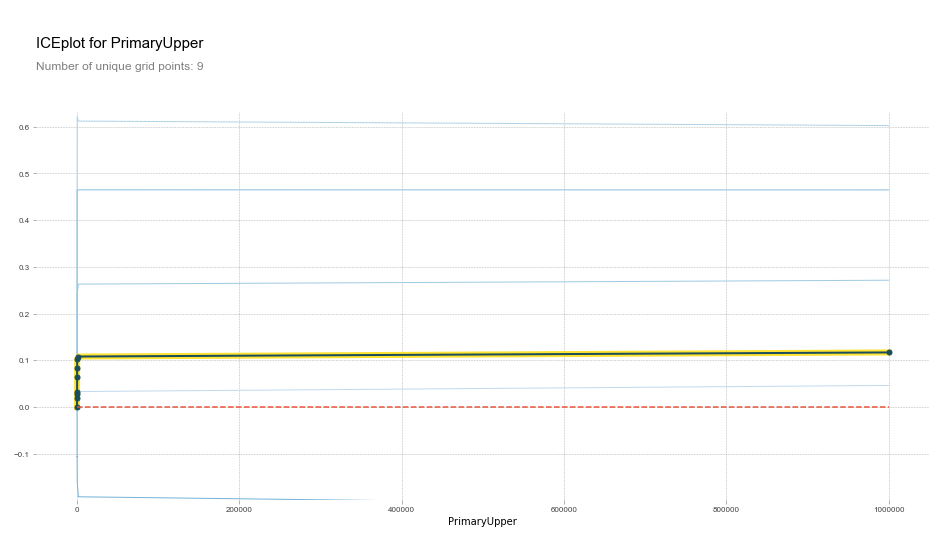

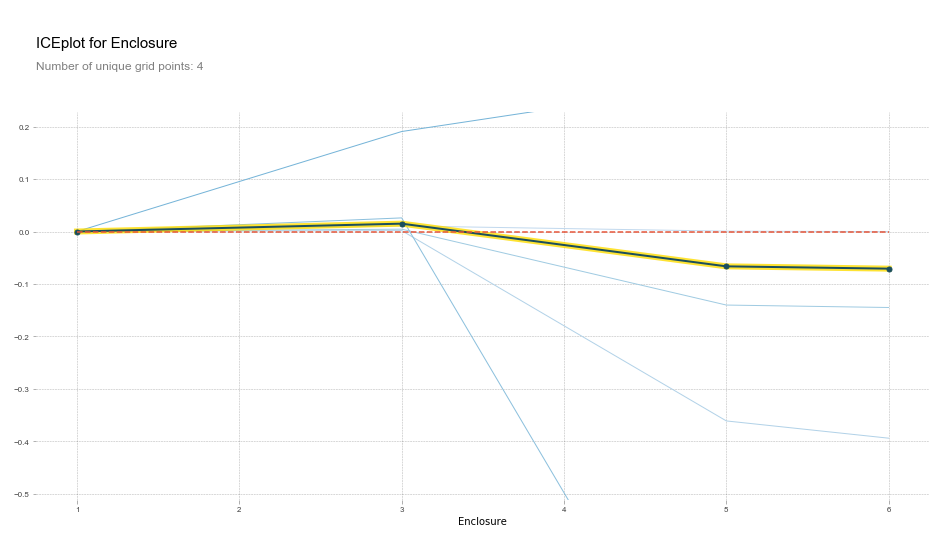

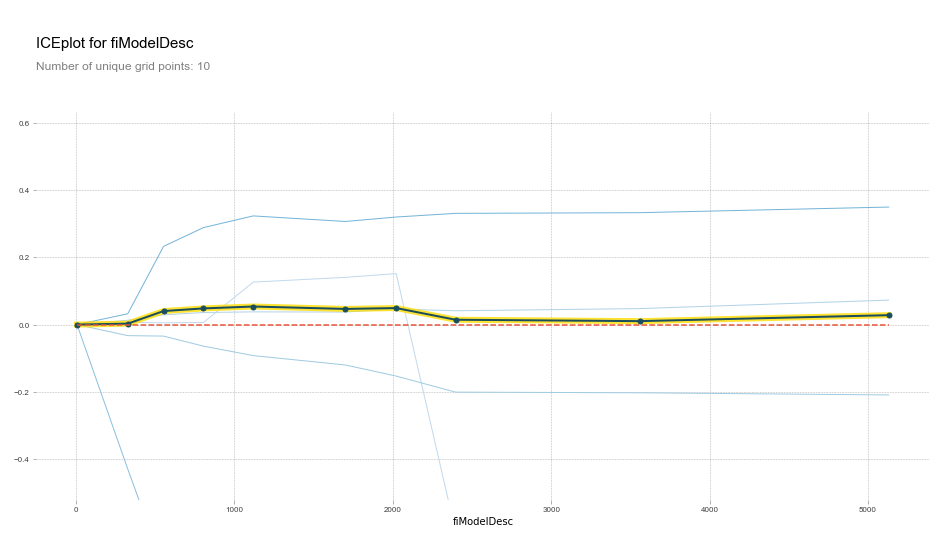

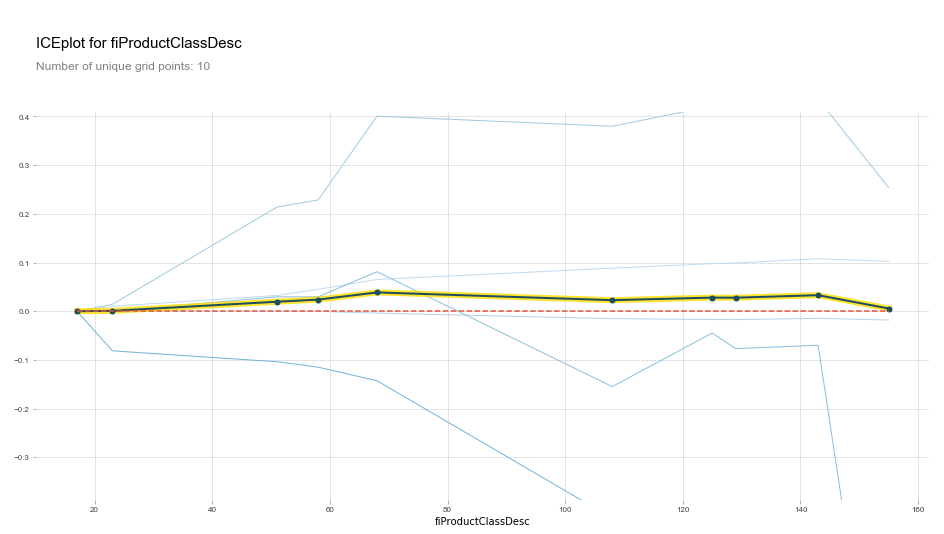

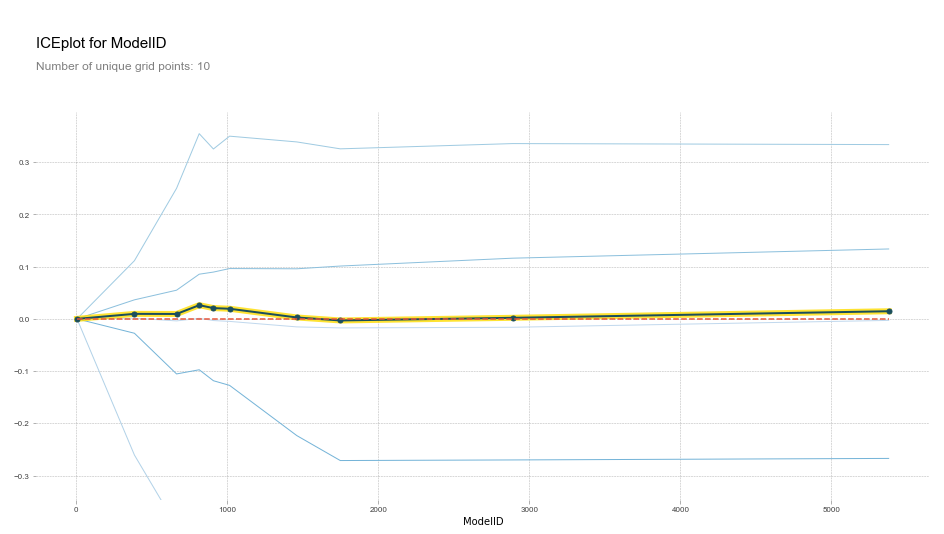

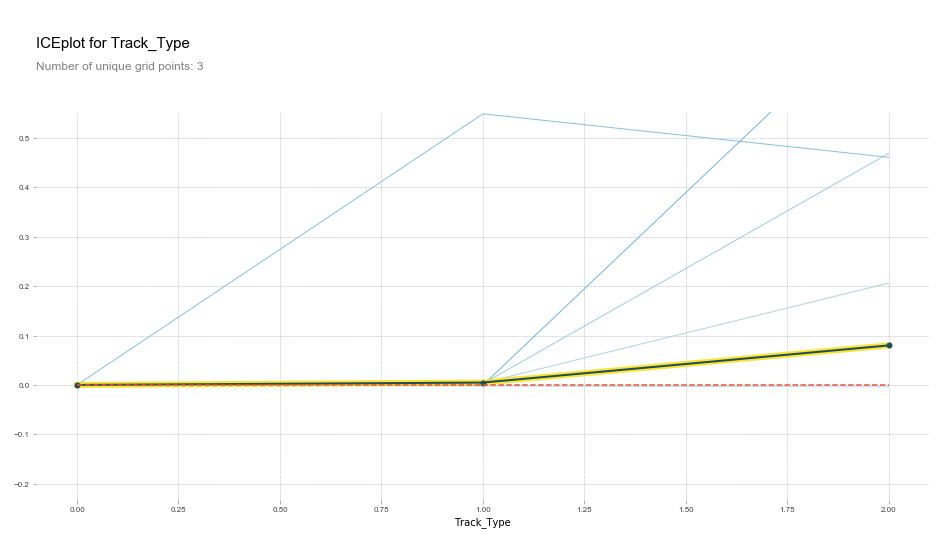

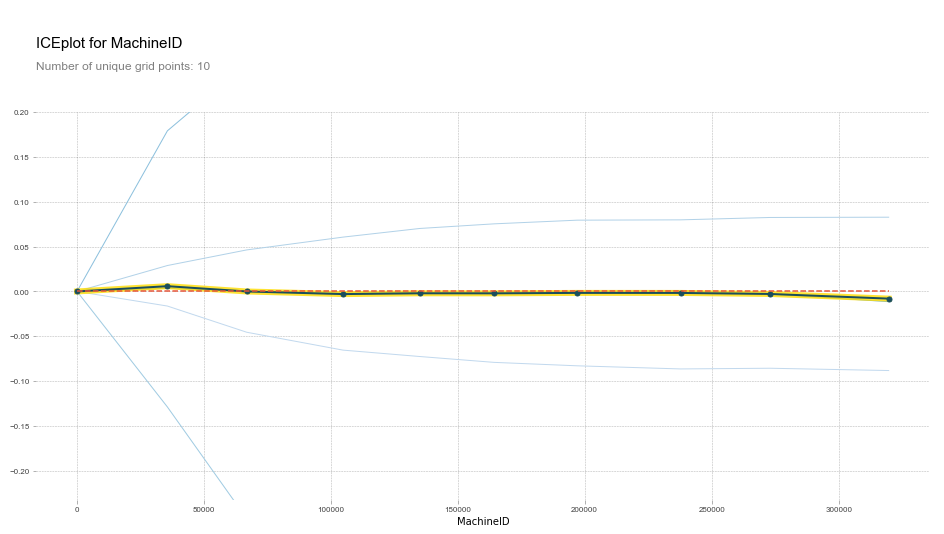

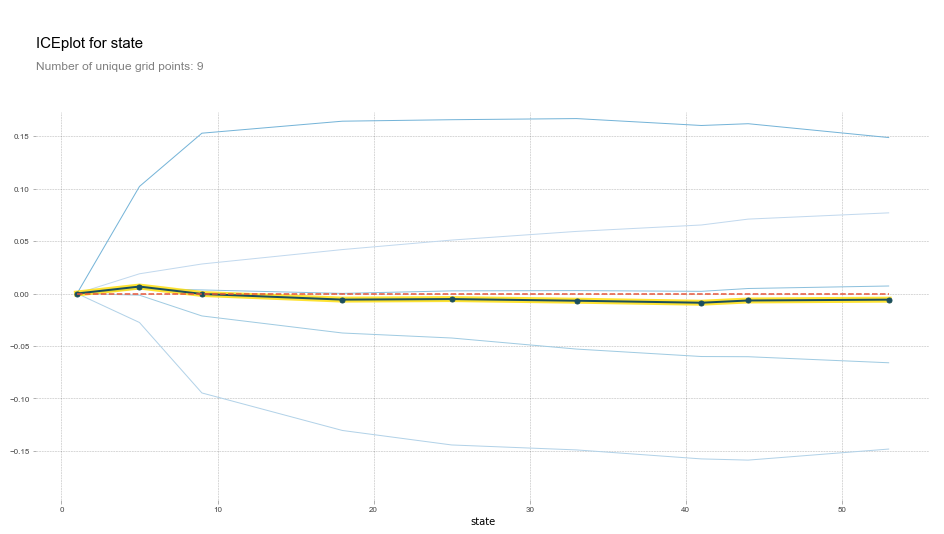

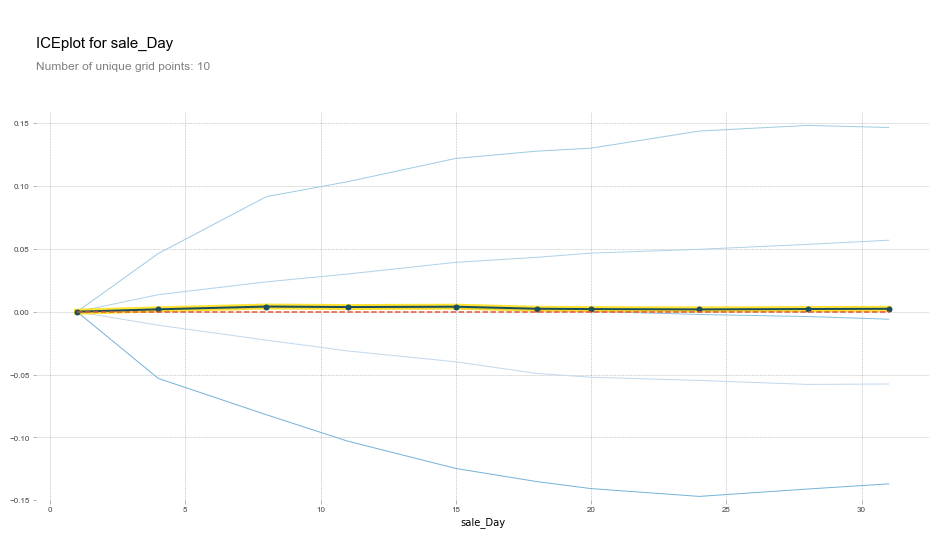

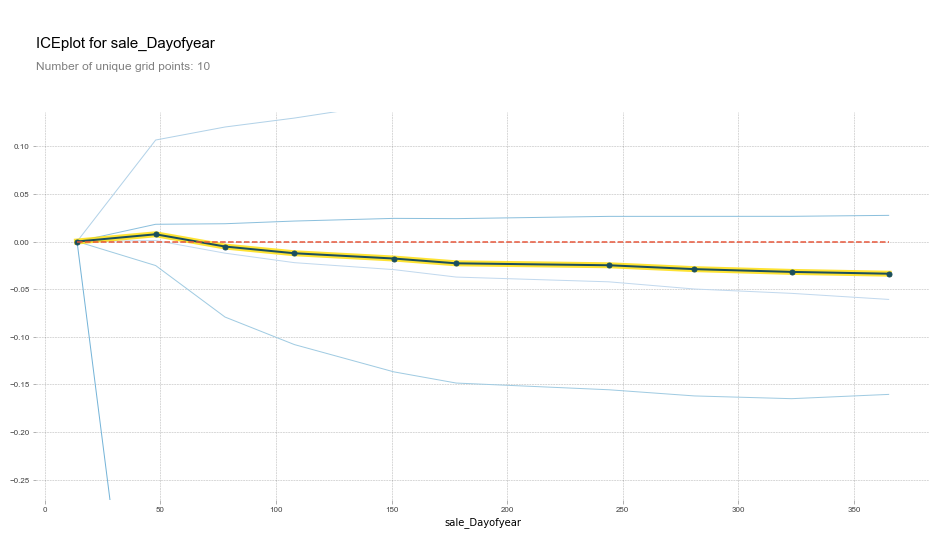

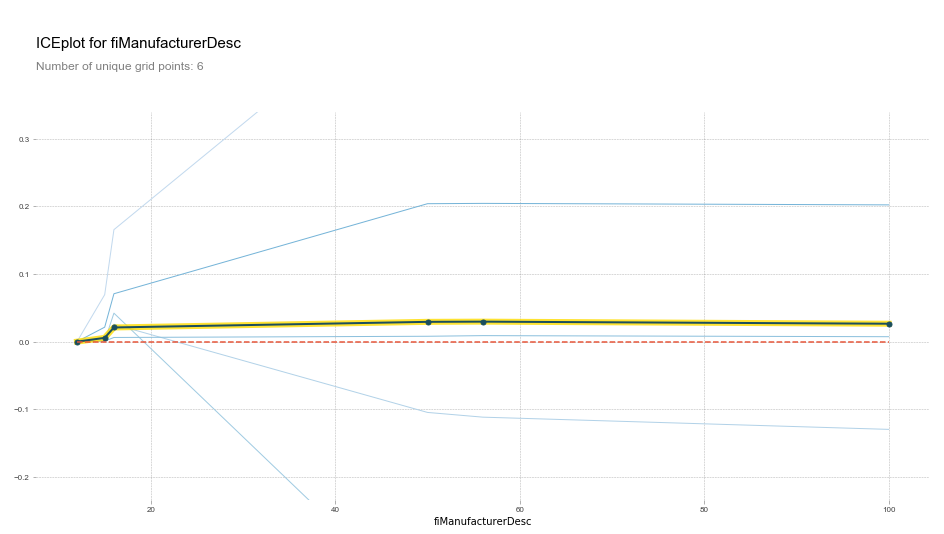

In [131]:
for feat in df_keep.columns:
    plot_pdp(feat, clusters=5)

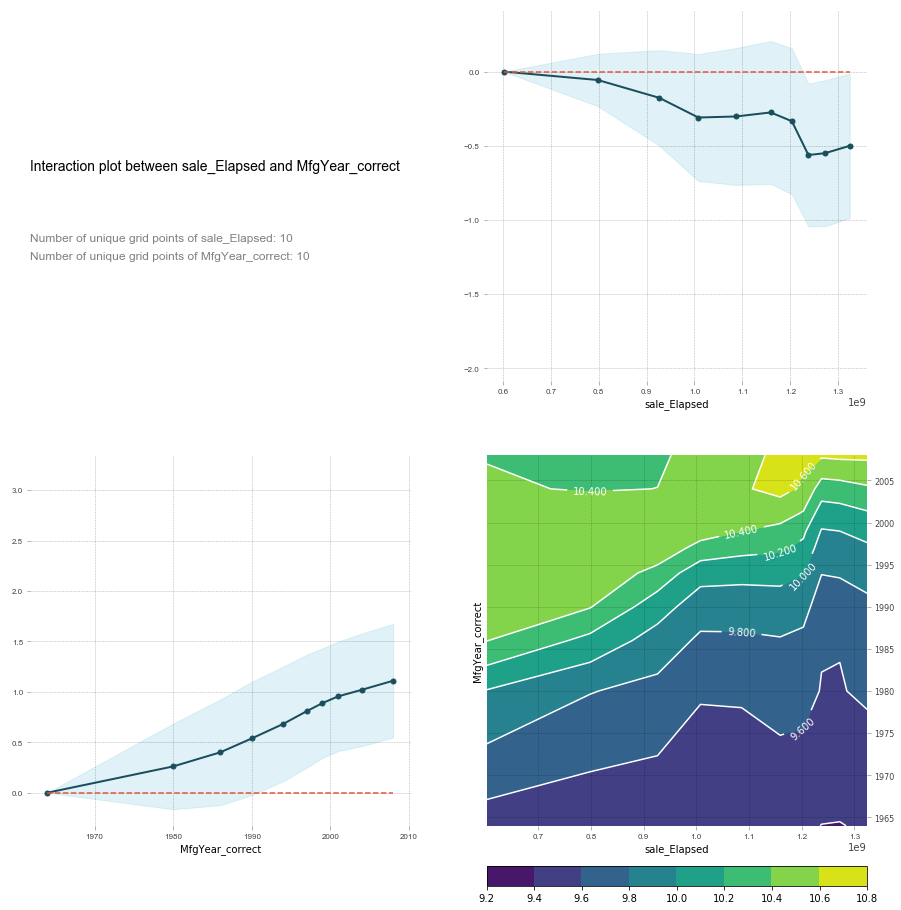

In [132]:
feats = ['sale_Elapsed', 'MfgYear_correct']
p = pdp.pdp_interact(random_forest, x_train_aux, feats)
pdp.pdp_interact_plot(p, feats)

In [134]:
df_merge["age"] = df_merge["sale_Year"]-df_merge["MfgYear_correct"]

## Extrapolation

In [189]:
df_keep = df_merge[feat_importance > 0.005].copy()
df_ext = df_keep.copy()
df_ext["is_valid"] = 1
# df_ext = df_ext.loc[:n_trn, "is_valid"] = 0
df_ext["is_valid"].values[:n_trn] = 0
y = df_ext["is_valid"].values
df_ext.drop("is_valid", axis=1, inplace=True)

KeyboardInterrupt: 

In [136]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y);
m.oob_score_

0.99673387416431047

In [137]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
7,SalesID,0.604939
3,sale_Elapsed,0.167346
14,MachineID,0.111740
17,sale_Dayofyear,0.016889
0,MfgYear_correct,0.015223
4,fiManufacturerID,0.015100
10,fiModelDesc,0.011057
12,ModelID,0.010683
18,fiManufacturerDesc,0.010017
16,sale_Day,0.007078


In [138]:
feats=['SalesID', 'sale_Elapsed', 'MachineID']

In [139]:
df_ext.drop(feats, axis=1, inplace=True)

In [140]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y)
m.oob_score_

0.97450255000924879

In [141]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
14,sale_Dayofyear,0.223195
12,state,0.140992
13,sale_Day,0.139504
0,MfgYear_correct,0.118424
10,ModelID,0.075938
8,fiModelDesc,0.070122
9,fiProductClassDesc,0.033936
7,Enclosure,0.033884
3,fiManufacturerID,0.032328
2,PrimaryLower,0.031689


In [452]:
feats=['SalesID', 'sale_Elapsed', 'MachineID', 'age', 'sale_Dayofyear', "MfgYear_correct", "sale_Day"]

In [453]:
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [455]:
scores_extra = pd.DataFrame({"baseline": print_score(m, x_train, y_train, x_valid, y_valid)})

RMSE train:  0.08031431532770775
RMSE valid:  0.23954527203242812
RF score train:  0.986368400378
RF score valid:  0.897980500438
RF oob:  0.902662644316


In [415]:
df_subs.shape

(378430, 18)

In [458]:
def print_score(rf, x_train, y_train, x_valid, y_valid):
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "RF score train": rf.score(x_train, y_train), "RF score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"RF oob": rf.oob_score_})
    for n, s in score.items():
        print(n+": ", s)
    return score

for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    x_train, x_valid = split_vals(df_subs, n_trn)
    y_train, y_valid = split_vals(sale_price, n_trn)
    m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    scores_extra = scores_extra.join(pd.DataFrame({f: print_score(m, x_train, y_train, x_valid, y_valid)}))
#    print_score(m, x_train, y_train, x_valid, y_valid)

RMSE train:  0.08034342185927516
RMSE valid:  0.2331989189561514
RF score train:  0.986358518193
RF score valid:  0.903314566782
RF oob:  0.902214898376
RMSE train:  0.0820393246289067
RMSE valid:  0.2504429808078703
RF score train:  0.985776546674
RF score valid:  0.888486945937
RF oob:  0.898059194537
RMSE train:  0.07970799508456117
RMSE valid:  0.2392270336306949
RF score train:  0.986573442697
RF score valid:  0.898251388326
RF oob:  0.903554068756
RMSE train:  0.08032489592146205
RMSE valid:  0.244316859112687
RF score train:  0.986364808493
RF score valid:  0.893875696013
RF oob:  0.902003797468
RMSE train:  0.0804902322139591
RMSE valid:  0.24008830946031315
RF score train:  0.986308618886
RF score valid:  0.897517429711
RF oob:  0.901729709483
RMSE train:  0.08039380777001982
RMSE valid:  0.24262608399427008
RF score train:  0.986341402815
RF score valid:  0.895339462859
RF oob:  0.901881602624
RMSE train:  0.08003408876707097
RMSE valid:  0.24295347264351722
RF score train:  

In [459]:
scores_extra

,baseline,SalesID,sale_Elapsed,MachineID,age,sale_Dayofyear,MfgYear_correct,sale_Day
RF oob,0.902663,0.902215,0.898059,0.903554,0.902004,0.901730,0.901882,0.902748
RF score train,0.986368,0.986359,0.985777,0.986573,0.986365,0.986309,0.986341,0.986463
RF score valid,0.897981,0.903315,0.888487,0.898251,0.893876,0.897517,0.895339,0.895057
RMSE train,0.080314,0.080343,0.082039,0.079708,0.080325,0.080490,0.080394,0.080034
RMSE valid,0.239545,0.233199,0.250443,0.239227,0.244317,0.240088,0.242626,0.242953


In [460]:
scores_extra.loc[["RF score valid", "RMSE valid"]].transpose().sort_values("RF score valid", ascending=False)

,RF score valid,RMSE valid
SalesID,0.903315,0.233199
MachineID,0.898251,0.239227
baseline,0.897981,0.239545
sale_Dayofyear,0.897517,0.240088
MfgYear_correct,0.895339,0.242626
sale_Day,0.895057,0.242953
age,0.893876,0.244317
sale_Elapsed,0.888487,0.250443


In [461]:
df_final = df_keep.drop(["SalesID", "MachineID", "sale_Dayofyear", "sale_Day"], axis=1)

In [472]:
x_train, x_valid = split_vals(df_final, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)

CPU times: user 2min 40s, sys: 2.71 s, total: 2min 43s
Wall time: 27.3 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [473]:
# scores.drop("extra", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"extra": print_score(m, x_train, y_train, x_valid, y_valid)}))

RMSE train:  0.08561430730649974
RMSE valid:  0.22867149598374578
RF score train:  0.984509922399
RF score valid:  0.907032308343
RF oob:  0.903090433084


In [474]:
scores

,baseline,feat_importance,correlation,extra
RF oob,0.906875,0.902184,0.902501,0.903090
RF score train,0.986958,0.986297,0.986429,0.984510
RF score valid,0.988677,0.893859,0.893776,0.907032
RMSE train,0.078558,0.080525,0.080137,0.085614
RMSE valid,0.079804,0.244336,0.244432,0.228671


In [475]:
feat_importance = pd.DataFrame({"cols": df_final.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False)

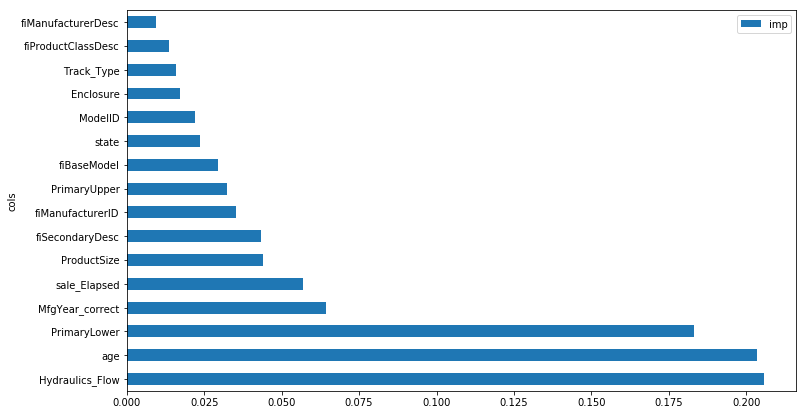

In [476]:
plot_feat_importance(feat_importance[:30])

## confidence on tree variance

In [478]:
%time preds = np.stack([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 212 ms, sys: 26 ms, total: 238 ms
Wall time: 237 ms


(10.887254871775234, 0.25594433579748516)